In [9]:
!pip install dython xgboost lightgbm joblib

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dython.nominal import associations

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [11]:

print(df.describe())
print(df.isnull().sum())
print(df['Churn'].value_counts())


df['TotalCharges'] = df['TotalCharges'].replace('', np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)

df['ChurnTarget'] = df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)


       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Churn
No     5174
Yes    1869
Name: count, dtype: int64


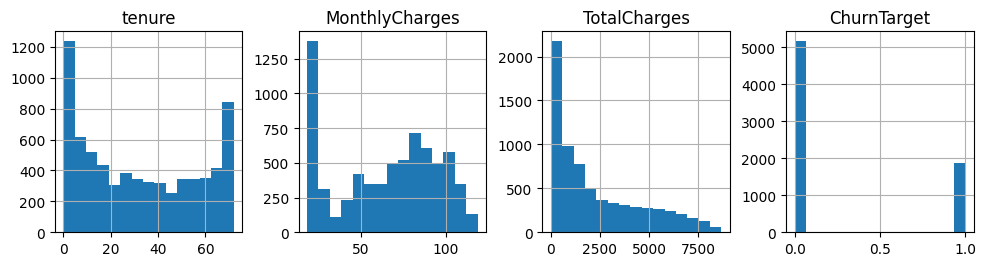

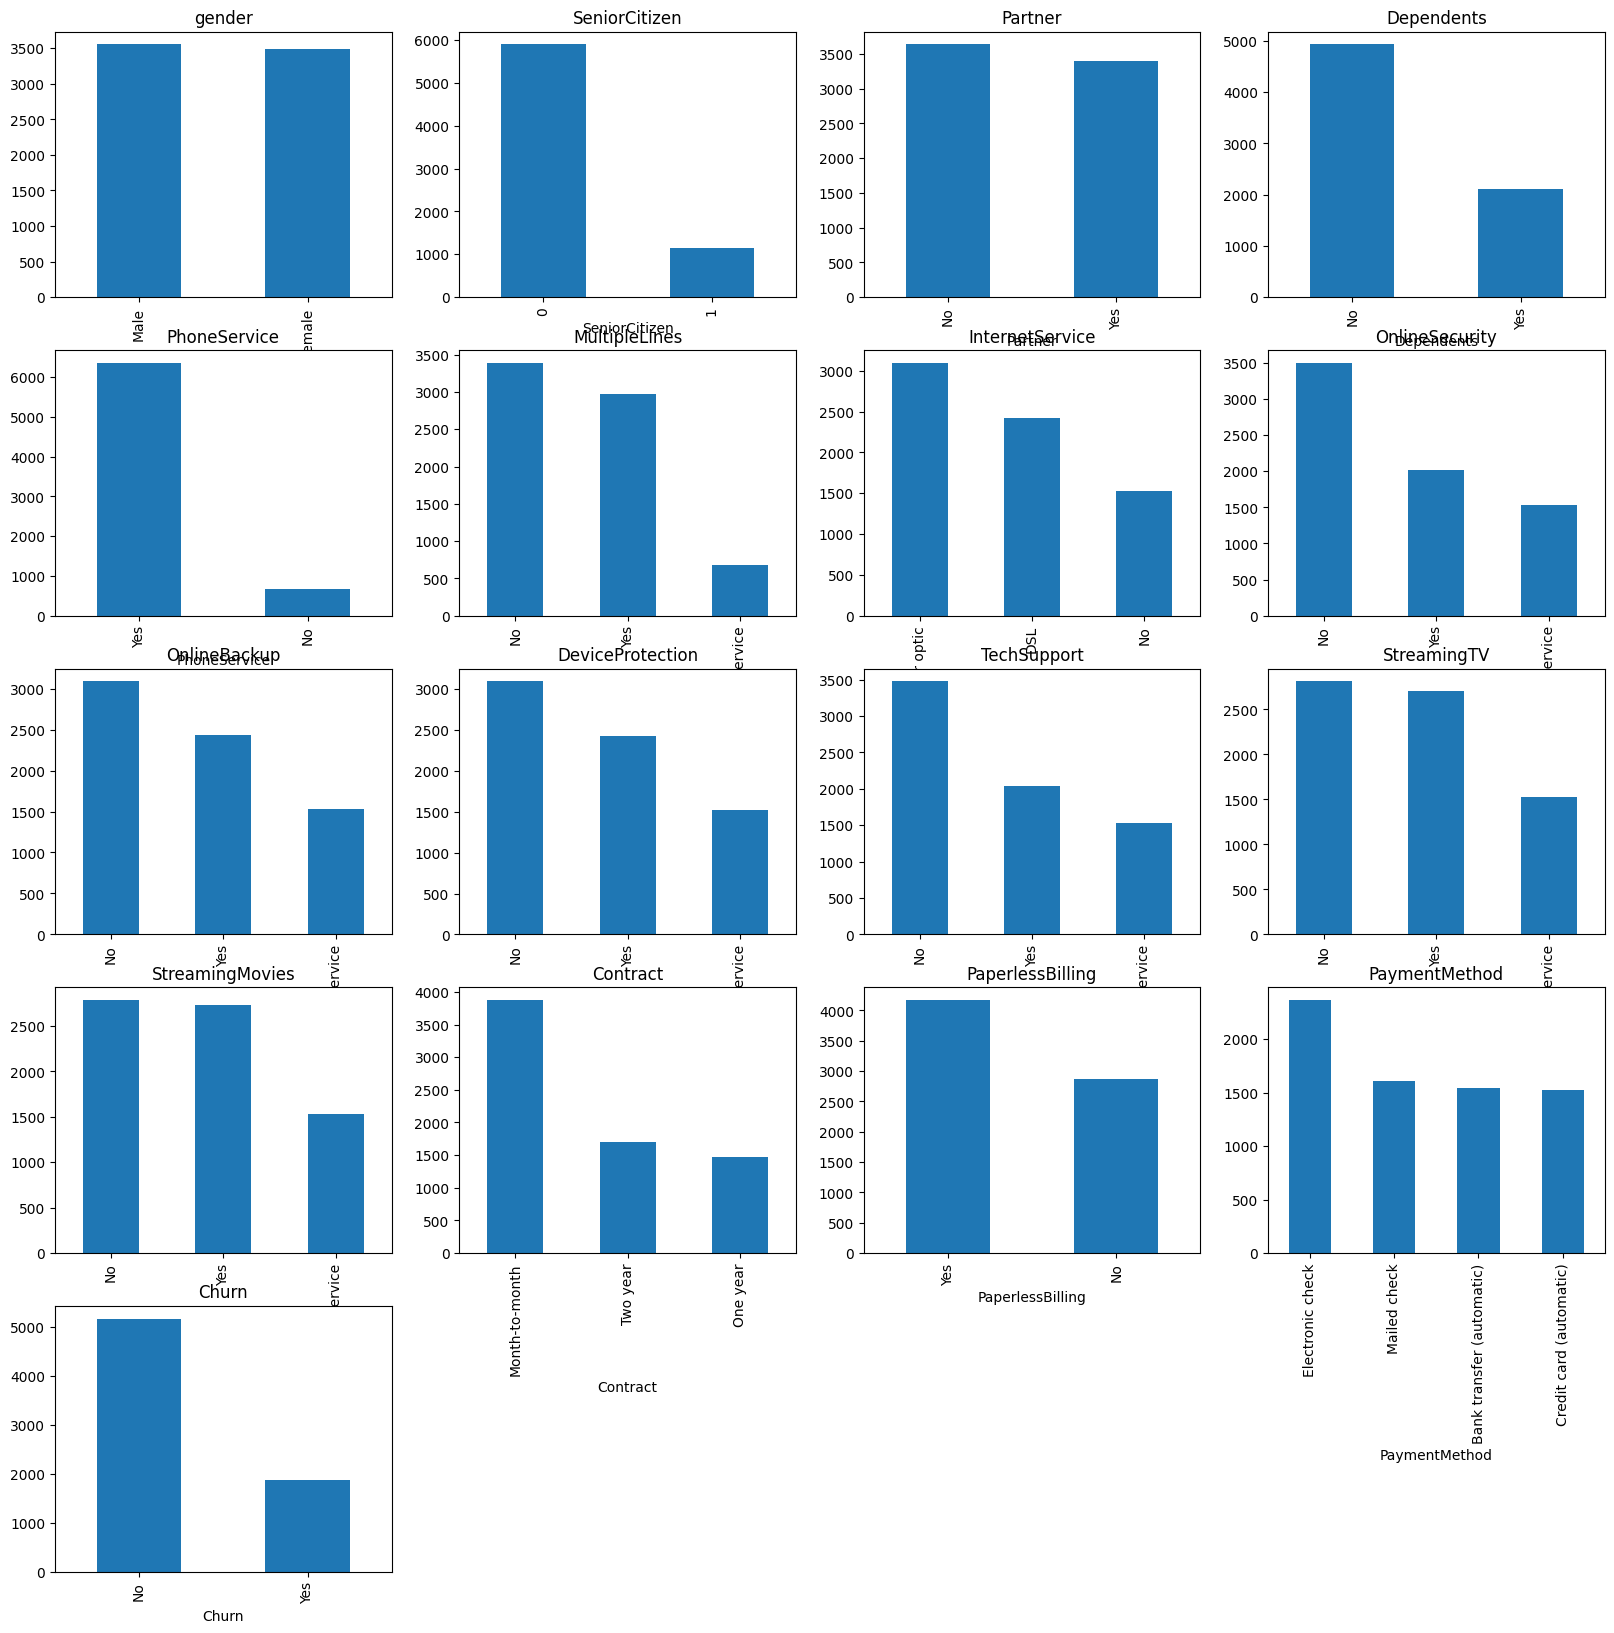

In [12]:

num_features = df.select_dtypes('number').columns
df[num_features].hist(bins=15, figsize=(15, 6), layout=(2, 5))
plt.show()


cat_features = df.drop('customerID', axis=1).select_dtypes(include='object').columns

plt.figure(figsize=(20, 20))
for i, col in enumerate(cat_features, 1):
    plt.subplot(5, 4, i)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
plt.show()


Selected Numeric Features: ['tenure']
Selected Categorical Features: ['InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaymentMethod']


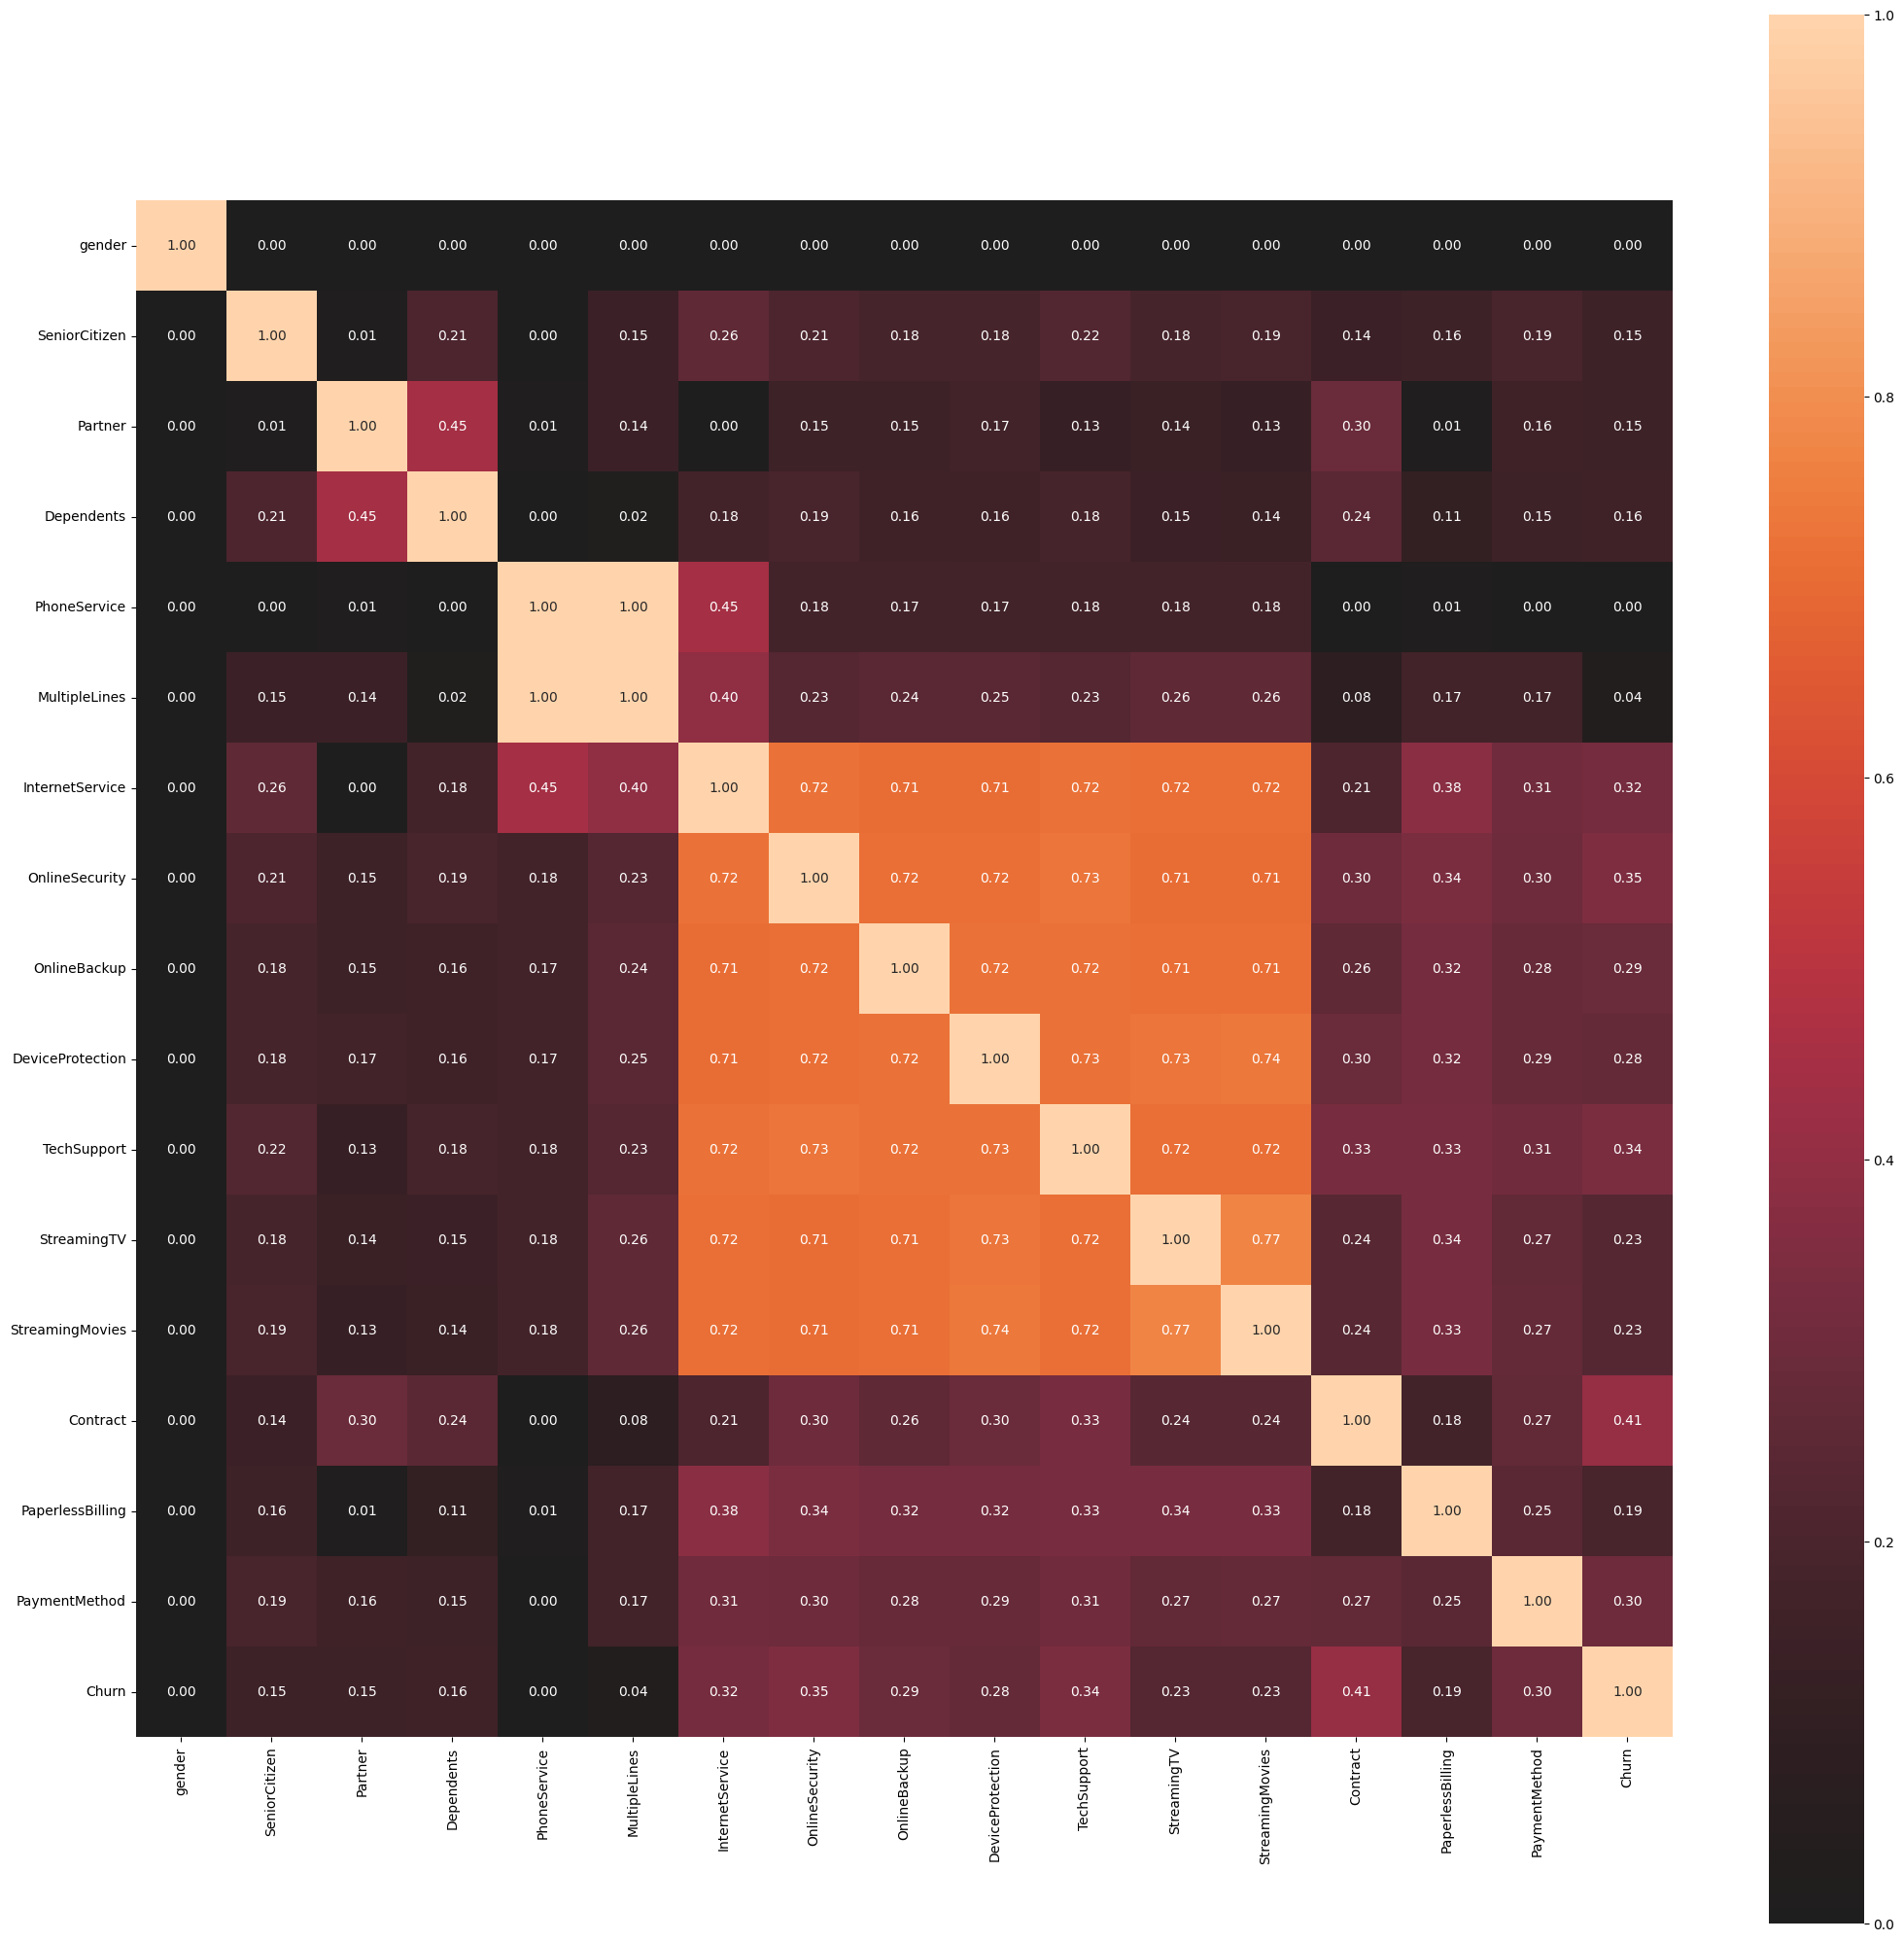

In [13]:

target = 'ChurnTarget'
num_features = df.select_dtypes(include=[np.number]).columns.drop(target)
correlations = df[num_features].corrwith(df[target])
selected_num_features = correlations[abs(correlations) > 0.3].index.tolist()


cat_features = df.drop('customerID', axis=1).select_dtypes(include='object').columns
assoc = associations(df[cat_features], nominal_columns='all', plot=False)
corr_matrix = assoc['corr']

selected_cat_features = corr_matrix[corr_matrix.loc['Churn'] > 0.3].index.tolist()
selected_cat_features = selected_cat_features[:-1]

print("Selected Numeric Features:", selected_num_features)
print("Selected Categorical Features:", selected_cat_features)

selected_features = selected_num_features + selected_cat_features


In [14]:
from sklearn.model_selection import train_test_split

X = df[selected_features]
y = df[target]

cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(include=['number']).columns.tolist()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,
                                                            random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.25, random_state=42,
                                                  stratify=y_train_val)


In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)

y_val_pred = pipeline.predict(X_val)
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__solver': ['lbfgs', 'liblinear']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

y_test_pred = grid_search.predict(X_test)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))


Best Hyperparameters: {'classifier__C': 1, 'classifier__solver': 'lbfgs'}
Test Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409



In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier()
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    recall = recall_score(y_test, y_pred)

    results.append((name, recall))

results


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:25:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 1121, number of negative: 3104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265325 -> initscore=-1.018470
[LightGBM] [Info] Start training from score -1.018470


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[('Logistic Regression', 0.5374331550802139),
 ('Decision Tree', 0.48128342245989303),
 ('Random Forest', 0.5240641711229946),
 ('SVM', 0.43315508021390375),
 ('Gradient Boosting', 0.5454545454545454),
 ('XGBoost', 0.5106951871657754),
 ('LightGBM', 0.5320855614973262)]

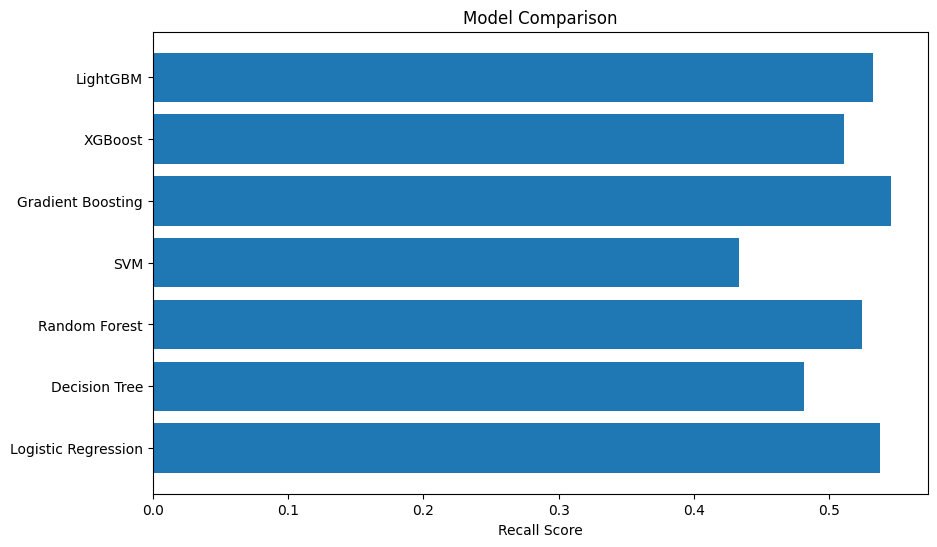

In [18]:
model_names = [r[0] for r in results]
test_recalls = [r[1] for r in results]

plt.figure(figsize=(10, 6))
plt.barh(model_names, test_recalls)
plt.xlabel('Recall Score')
plt.title('Model Comparison')
plt.show()


In [19]:
import joblib

best_model = grid_search.best_estimator_
joblib.dump(best_model, 'logreg_model.joblib')
print("Model saved as logreg_model.joblib")


Model saved as logreg_model.joblib
